In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import altair as alt

%matplotlib inline

# Import Data:

- Explore the data.
- Pick a starting point and create visualizations that might help understand the data better.
- Come back and explore other parts of the data and create more visualizations and models.

Quandl is a great place to start exploring datasets and has the Zillow Research Datasets(and many other datasets) that can be merged to create the customized dataset that might provide solutions to a specific problem.
It also has an easy to use api. I started with the Zillow data because it was the first real estate dataset on the Quandl site and it contains a lot of metrics that look interesting. 

In [2]:
import quandl

quandl.ApiConfig.api_key = '############'

I downloaded the Zillow codes dataset: https://www.quandl.com/data/ZILLOW-Zillow-Real-Estate-Research/usage/export
This was useful while exploring area specific codes and descriptions in Zillow Research Dataset which contains 1,318,489 datasets. One can use regular expressions among other tools during EDA.

In [3]:
zillow_codes = pd.read_csv('input/ZILLOW-datasets-codes.csv',header=None)
zillow_codes.columns = ['codes','description']

## API Reference:

https://blog.quandl.com/api-for-housing-data


In [4]:
def cleanup_desc(df):
    '''Function cleans up description column of Zillow codes dataframe.'''
    df.description.values[:] = (df.loc[:,'description']).str.split(':').apply(lambda x: x[1].split('- San Francisco, CA')).apply(lambda x:x[0])
    return df

def get_df(df,col='code',exp='/M'):
    ''' 
    Function takes in the zillow_codes dataframe and ouputs 
    a dataframe filtered by specified column and expression:
    
    Inputs:
    col: 'code' or 'description'
    exp: string Reference: https://blog.quandl.com/api-for-housing-data
    
    Ouputs:
    pd.DataFrame
    '''
    indices = [i for i,val in enumerate(df[col].str.findall(exp)) if val != []]
    print('Number of data points: {}'.format(len(indices)))
    return df.iloc[indices,:]



In [5]:
def print_random_row(df):
    randint = np.random.randint(df.shape[0])
    print(df.codes.iloc[randint])
    print(df.description.iloc[randint])

In [6]:
print_random_row(zillow_codes)

ZILLOW/C12142_MSPFSF
Zillow Home Value Index (City): Median Sold Price Per Square Foot - Single-Family Residence - Hoffman Estates, IL


In [7]:
#Zip with Regex:
zip_df = get_df(zillow_codes,col='codes',exp=r'/Z94[0-9][0-9][0-9]_')

Number of data points: 6518


In [8]:
print_random_row(zip_df)

ZILLOW/Z94123_ZHVI3B
Zillow Home Value Index (Zip): Zillow Home Value Index - Three Bedrooms - 94123, San Francisco, CA


In [9]:
#Metro Code: '/M'
metro_df = get_df(zillow_codes,col='codes',exp='/M12')

Number of data points: 700


In [10]:
print_random_row(metro_df)

ZILLOW/M121_ZHVIBT
Zillow Home Value Index (Metro): Zillow Home Value Index - Bottom Tier - Santa Cruz, CA



## Percent of homes increasing in value:

- Percent of homes increasing in value is a metric that may be useful while making the decision to buy or rent.
- Using the code is "/Z" for getting data by zipcode.
- Using the description to filter the data to Chicago zipcodes.
- There are ~1.38M Zillow Research datasets on Quandl and such filters come in handy while exploring data.
- Make API call to Quandl and get the percent of homes increasing values for all homes by neighborhood in Chicago.(http://www.realestatedecoded.com/zillow-percent-homes-increasing-value/)


In [11]:
#Getting neighborhood level information: '/N' 
#Getting metro level information: '/M'

neighborhoods = get_df(zillow_codes,col='codes',exp='/N')
zips = get_df(zillow_codes,col='codes',exp='/Z')

Number of data points: 204611
Number of data points: 582471


In [12]:
zips_chicago = get_df(zips,col='description',exp='Chicago, IL')

Number of data points: 2769


In [13]:
#  neighborhoods_sfo = get_df(neighborhoods,col='description',exp=' San Francisco, CA')
neighborhoods_chicago = get_df(neighborhoods,col='description',exp='Chicago, IL')

Number of data points: 5722


In [14]:
print_random_row(neighborhoods_chicago)

ZILLOW/N552_MRPFMF
Zillow Home Value Index (Neighborhood): Median Rental Price Per Square Foot - Multi-Family Residence - University Village - Little Italy, Chicago, IL


In [15]:
#A quantity of interest while buying a home maybe median sale price per sq ft. of homes in various neighborhoods around SFO.
#Filtering the codes according to the reference.

#mspf = Median Sale Price per Square Foot
# mspf_neighborhoods_sfo = get_df(neighborhoods_sfo,col='codes',exp='_MSPFAH')

#prr = Price to rent ratio

# prr_neighborhoods_sfo = get_df(neighborhoods_sfo,col='codes',exp='_PRRAH')

#phi = Percent of Homes increasing in values - all homes
phiv_neighborhoods_chicago = get_df(neighborhoods_chicago,col='codes',exp='_PHIVAH')
phiv_zips_chicago = get_df(zips_chicago,col='codes',exp='_PHIVAH')

Number of data points: 165
Number of data points: 56


In [16]:
print_random_row(phiv_zips_chicago)

ZILLOW/Z60640_PHIVAH
Zillow Home Value Index (Zip): Percent Of Homes Increasing In Values - All Homes - 60640, Chicago, IL


In [17]:
#Clearning up descriptions:

neighborhood_names = phiv_neighborhoods_chicago.description.apply(lambda x: x.replace('Zillow Home Value Index (Neighborhood): Percent Of Homes Increasing In Values - All Homes - ',''))
zips_names = phiv_zips_chicago.description.apply(lambda x:x.replace('Zillow Home Value Index (Zip): Percent Of Homes Increasing In Values - All Homes - ',''))

In [18]:
zips_names[:1]

931463    60657, Chicago, IL
Name: description, dtype: object

In [19]:
neighborhood_names[:1]

177782    Logan Square, Chicago, IL
Name: description, dtype: object

In [20]:
def get_quandl_data(df,names,filter_val=246):
    quandl_get = [quandl.get(code) for i,code in enumerate(df['codes'])]
    
    #Cleaned up DF and DF columns
    cleaned_up = pd.concat([val for i,val in enumerate(quandl_get) if val.shape[0]>=filter_val],axis=1)
    cleaned_names = [names.iloc[i] for i,val in enumerate(quandl_get) if val.shape[0]>=filter_val]
    cleaned_up.columns = cleaned_names
    #Some time series have fewer than 246 data points, ignoring these points for the moment.
    #Saving the indices and time series in a separate anomaly dict with {name:ts}
    
    anomaly_dict = {names.iloc[i]:val for i,val in enumerate(quandl_get) if val.shape[0]<filter_val}
    return quandl_get,anomaly_dict,cleaned_up

In [21]:
#  = get_quandl_data(phiv_neighborhoods_chicago)
phiv_quandl_get_list,phiv_anomaly_dict,phiv_chicago_neighborhoods_df = get_quandl_data(phiv_neighborhoods_chicago,neighborhood_names)
phiv_chicago_neighborhoods_df.sample(2)

,"Logan Square, Chicago, IL","Little Village, Chicago, IL","West Rogers Park, Chicago, IL","Albany Park, Chicago, IL","Rogers Park, Chicago, IL","South Austin, Chicago, IL","Archer Heights, Chicago, IL","Gresham, Chicago, IL","Lake View, Chicago, IL","Englewood, Chicago, IL",...,"Printers Row, Chicago, IL","Pill Hill, Chicago, IL","LeClaire Courts, Chicago, IL","Chrysler Village, Chicago, IL","Roscoe Village, Chicago, IL","Forest Glen, Chicago, IL","Schorsch Forest View, Chicago, IL","Burnside, Chicago, IL","West Chatham, Chicago, IL","South Commons, Chicago, IL"
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-31,75.77,85.47,78.21,74.54,67.24,82.12,80.04,77.49,50.96,60.42,...,67.04,94.69,95.39,98.58,57.05,91.07,65.71,91.27,55.48,90.77
2015-10-31,55.27,48.39,56.04,62.20,59.68,31.50,54.12,43.89,50.09,11.55,...,27.03,66.23,19.43,36.03,65.19,61.17,56.59,35.27,40.84,84.80


In [22]:
phiv_quandl_get_list,phiv_anomaly_dict,phiv_chicago_zips_df = get_quandl_data(phiv_zips_chicago,zips_names)

In [23]:
phiv_chicago_zips_df.shape

(246, 55)

In [24]:
phiv_chicago_zips_df.sample(10)

,"60657, Chicago, IL","60614, Chicago, IL","60640, Chicago, IL","60647, Chicago, IL","60618, Chicago, IL","60613, Chicago, IL","60629, Chicago, IL","60625, Chicago, IL","60619, Chicago, IL","60617, Chicago, IL",...,"60655, Chicago, IL","60636, Chicago, IL","60185, West Chicago, IL","60646, Chicago, IL","60601, Chicago, IL","60642, Chicago, IL","60661, Chicago, IL","60064, North Chicago, IL","60633, Chicago, IL","60606, Chicago, IL"
Date,,,,,,,,,,,,,,,,,,,,,
2003-09-30,53.06,54.24,77.92,77.87,77.69,62.93,88.88,85.37,72.32,66.50,...,88.36,81.39,84.86,75.74,36.68,75.07,74.89,68.93,67.12,49.77
2017-07-31,64.12,58.70,63.33,75.78,65.79,55.26,56.91,63.14,65.59,50.40,...,77.07,66.72,90.02,78.04,68.10,74.40,84.47,83.48,82.97,80.23
2009-12-31,36.22,39.73,32.03,28.33,22.53,39.30,6.05,23.65,11.71,22.46,...,32.62,9.88,11.76,14.55,39.63,48.16,50.59,3.10,25.87,57.88
2003-08-31,58.20,60.07,82.81,78.70,79.69,65.94,90.96,84.88,72.53,67.15,...,88.12,81.00,86.45,78.34,42.15,83.31,70.09,65.37,70.07,40.83
1998-04-30,72.93,56.27,72.68,44.37,70.09,70.42,62.59,81.66,46.70,60.74,...,50.90,38.52,66.41,66.75,34.75,56.08,48.82,84.37,57.14,29.40
2012-11-30,37.20,46.31,30.58,51.10,46.25,36.69,46.21,31.94,40.58,24.62,...,38.87,54.47,40.19,45.88,25.05,49.02,46.35,42.92,9.32,34.03
2007-03-31,44.95,39.84,54.08,59.91,52.65,42.92,58.43,45.89,70.95,75.65,...,63.68,66.39,46.67,59.48,63.85,39.89,63.52,44.84,57.70,58.25
2006-02-28,77.12,77.93,73.34,89.50,84.37,61.48,97.12,79.69,92.34,92.46,...,93.66,95.03,93.05,93.37,88.29,87.04,66.96,95.92,94.40,51.53
2011-07-31,11.99,20.31,7.80,14.65,13.66,8.65,3.59,8.26,6.56,8.34,...,3.87,7.68,3.06,8.98,48.92,10.94,4.00,5.21,7.54,9.73


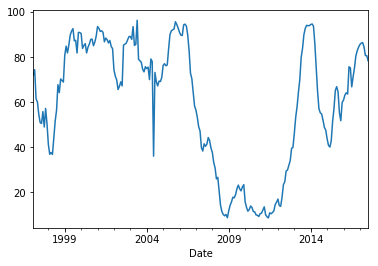

In [26]:
phiv_chicago_neighborhoods_df['Logan Square, Chicago, IL'].plot()

In [27]:
phiv_chicago_neighborhoods_df.to_csv('input/phiv_chicago_neighborhoods_df.csv')
phiv_chicago_zips_df.to_csv('input/phiv_zips_df.csv')

In [28]:
# phiv_chicago_neighborhoods = pd.read_csv('input/phiv_chicago_neighborhoods_df.csv')
phiv_chicago_fil_neigh_df = pd.read_csv('input/phiv_chicago_fil_neigh_df.csv')
phiv_chicago_fil_neigh_df.set_index('Date',inplace=True)

In [29]:
# phiv_chicago_neighborhoods_df.shape
gc.collect()

1287

# Using Prophet for time series forecasting:

    "Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers." -
    
https://facebookincubator.github.io/prophet/


In [30]:
from fbprophet import Prophet

In [31]:
data = phiv_chicago_zips_df['60647, Chicago, IL']
m = Prophet(mcmc_samples=200,interval_width=0.95,weekly_seasonality=False,changepoint_prior_scale=4,seasonality_prior_scale=1)

In [32]:
data = phiv_chicago_neighborhoods_df['Logan Square, Chicago, IL']
m = Prophet(mcmc_samples=200,interval_width=0.95,weekly_seasonality=False,changepoint_prior_scale=4)

In [33]:
# data = np.log(data)
data = pd.DataFrame(data).reset_index()
data.columns=['ds','y']
# data = data[data['ds'].dt.year>2009]
data.sample(10)

# m.fit(data)

,ds,y
117,2006-11-30,64.18
48,2001-02-28,92.76
108,2006-02-28,89.75
83,2004-01-31,74.91
200,2013-10-31,94.12
55,2001-09-30,86.31
6,1997-08-31,50.61
40,2000-06-30,84.41
168,2011-02-28,12.26
14,1998-04-30,36.86


In [34]:
params = dict(mcmc_samples=200,interval_width=0.98,weekly_seasonality=False,changepoint_prior_scale=0.5)

In [35]:
def prophet_forecast(data,params,periods=4,freq='BMS'):
    m = Prophet(**params)
    data = pd.DataFrame(data).reset_index()
    data.columns=['ds','y']
#     data = data[data['ds'].dt.year>2008]
#     print(data.sample(10))
    m.fit(data)
    future = m.make_future_dataframe(periods=4,freq=freq)#'M')
#     print(type(future))
    forecast = m.predict(future)
    return m,forecast

In [36]:
data = phiv_chicago_zips_df['60645, Chicago, IL']
m,forecast = prophet_forecast(data,params)

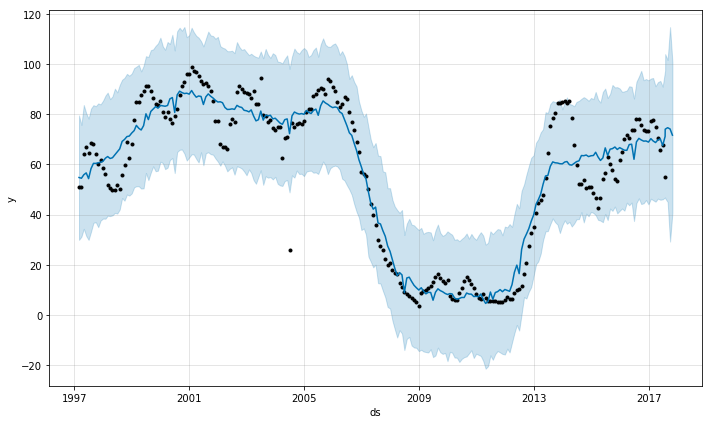

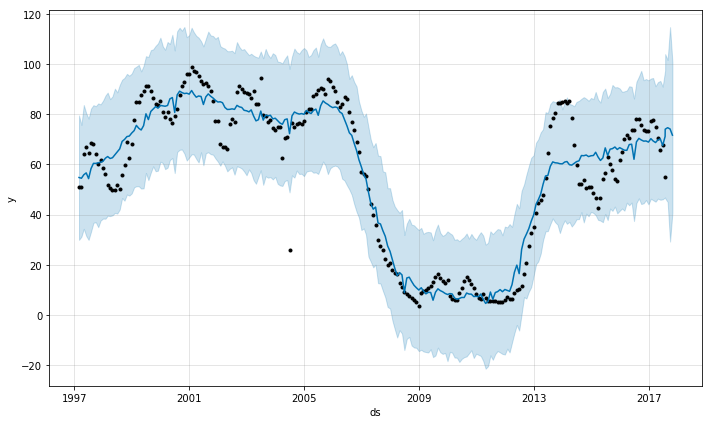

In [37]:
# forecast = m.predict()
m.plot(forecast)

In [38]:
# data

# Creating a chart using Altair:
This provides a pythonic interface to Vega-lite and makes it easy to create plots: https://altair-viz.github.io/


In [39]:
def area_chart_create(fcst,cols,trend_name='PHIC(%)',title='60645'):
    #Process data:
    fcst = fcst[cols]
#     fcst.loc[:,'ymin']=fcst[cols[2]]+fcst[cols[3]]#+fcst['trend']
#     fcst.loc[:,'ymax']=fcst[cols[2]]+fcst[cols[4]]#+fcst['trend']
    chart = alt.Chart(fcst).mark_area().encode(
    x = alt.X(fcst.columns[0]+':T',title=title,
        axis=alt.Axis(
            ticks=20,
            axisWidth=0.0,
            format='%Y',
            labelAngle=0.0,
        ),
        scale=alt.Scale(
            nice='month',
        ),
        timeUnit='yearmonth',
    ),
    
    y= alt.Y(fcst.columns[3]+':Q',title=trend_name),
    y2=fcst.columns[4]+':Q')
    return chart.configure_cell(height=200.0,width=700.0,)

In [40]:
# cols = ['ds','trend']+['yearly','yearly_lower','yearly_upper']
cols = ['ds','trend']+['yhat','yhat_lower','yhat_upper']

yhat_uncertainity = area_chart_create(forecast,cols=cols)

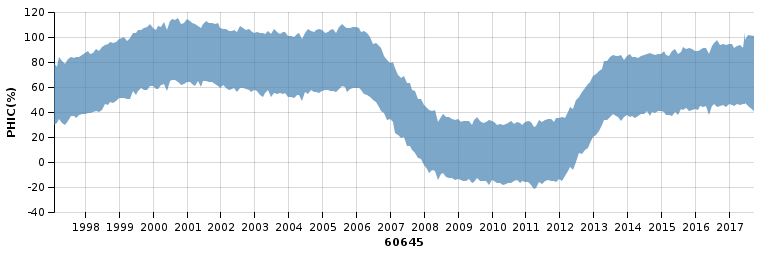

In [41]:
yhat_uncertainity

In [42]:
def trend_chart_create(fcst,trend_name='PHIC(%)trend'):
    chart = alt.Chart(fcst).mark_line().encode(
        color= alt.Color(value='#000'),
    x = alt.X(fcst.columns[0]+':T',title='Logan Sq',
        axis=alt.Axis(ticks=10,
            axisWidth=0.0,
            format='%Y',
            labelAngle=0.0,
        ),
        scale=alt.Scale(
            nice='month',
        ),
        timeUnit='yearmonth',
    ),
    y=alt.Y(fcst.columns[2]+':Q',title=trend_name)
    )
    return chart.configure_cell(height=200.0,width=700.0,)

In [43]:
trend = trend_chart_create(forecast)

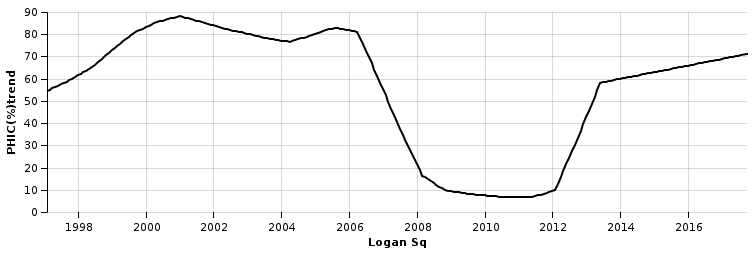

In [44]:
trend

## Layered Vega-lite chart created using Altair:


In [45]:
layers = [yhat_uncertainity,trend]

In [46]:
lchart = alt.LayeredChart(forecast,layers = layers)

In [47]:
cols = ['ds','trend']+['yhat','yhat_lower','yhat_upper']
def create_unc_chart(fcst,cols=cols,tsname='% of Homes increasing in value',title='Logan Sq'):
    ''' 
    Create Chart showing the trends and uncertainity in forecasts.
    
    '''
    
    yhat_uncertainity = area_chart_create(fcst,cols=cols,trend_name=tsname,title=title)
    trend = trend_chart_create(fcst,trend_name=tsname)
    
    layers = [yhat_uncertainity,trend]
    
    unc_chart = alt.LayeredChart(fcst,layers=layers)
    return unc_chart
    

In [48]:
unc_chart = create_unc_chart(forecast,title='60645')

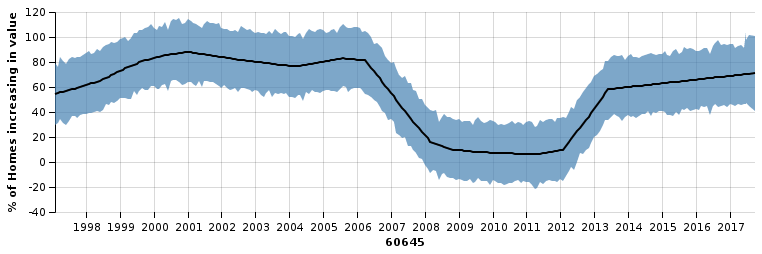

In [49]:
unc_chart

## Geopy: 

- Geopy is great for geocoding and geolocation: 
- It provides a geocoder wrapper class for the OpenStreetMap Nominatim class.
- It is convenient and can be used for getting latitude and longitude information from addresses.
- https://github.com/geopy/geopy

In [50]:
from geopy.geocoders import Nominatim

In [51]:
geolocator = Nominatim()

In [52]:
#Example:
location = geolocator.geocode("60647")
location

Location(Chicago, Cook County, Illinois, 60647, United States of America, (41.9173964264724, -87.6993218600089, 0.0))

### Getting the geocoder locations from addresses:

In [59]:
from time import sleep

def get_lat_lon(location):
        
        lat = location.latitude
        lon = location.longitude
        return lat,lon
    
def get_locations_list(address_list,geolocator,wait_time=np.arange(10,20,5)):
    '''
    Function returns the geocoded locations of addresses in address_list.
    
    Input:
    address_list : Python list
    
    Output:
    locations: Python list containing geocoded location objects.
    '''
    
    locations = []
    for i,addr in enumerate(address_list):
#         print(addr)
        sleep(5)
        loc = geolocator.geocode(addr)
        lat = loc.latitude
        lon = loc.longitude    
        locations.append((addr,lat,lon))
#         print(lat,lon)
        sleep(1)
    return locations

In [60]:
zip_list = phiv_chicago_zips_df.columns.tolist()
zip_locations= get_locations_list(zip_list,geolocator)

In [61]:
zip_locations[:2]

[('60657, Chicago, IL', 41.9397553561784, -87.6577783611167),
 ('60614, Chicago, IL', 41.9223100964062, -87.651617455372)]

In [62]:
zips_lat_lon = pd.DataFrame(zip_locations)
zips_lat_lon.columns=['zip','lat','lon']

In [63]:
zips_lat_lon.sample(2)

,zip,lat,lon
12,"60620, Chicago, IL",41.76498,-87.655622
52,"60064, North Chicago, IL",42.32626,-87.855495


# Folium plots:
- Using openstreetmaps(https://www.openstreetmap.org) to create a map with popup forecasts on zip code markers.
- Folium makes it easy to plot data on interactive maps. 
- It provides an interface to the Leaflet.js library.
- Open .html file in browser to view the interactive map

In [64]:
import folium
from folium import plugins

In [65]:
params = dict(mcmc_samples=20,interval_width=0.95,weekly_seasonality=False,changepoint_prior_scale=4)

In [66]:
map_name='CHI_zips_cluster_phiv_forecast.html'
map_osm = folium.Map(location=[41.8755546,-87.6244212],zoom_start=10)
marker_cluster = plugins.MarkerCluster().add_to(map_osm)

for name,row in zips_lat_lon[:].iterrows():
    address = row['zip']
    if pd.isnull(address):
        continue
    data = phiv_chicago_zips_df[address]
    m,forecast = prophet_forecast(data,params)
    unc_chart = create_unc_chart(forecast,title=address)

    unc_chart = unc_chart.to_json()
        
    popchart = folium.VegaLite(unc_chart)
    popup = folium.Popup(max_width=800).add_child(popchart)

    lat = row['lat']
    lon = row['lon']

    folium.Marker(location=(lat,lon),popup=popup).add_to(marker_cluster)
map_osm.save(map_name)